In [1]:
import pandas as pd
df = pd.read_csv("flightdelayscore_model.csv")
df.head()

,Month,DayOfWeek,Carrier,OriginAirportID,DestAirportID,DepDel15,ArrDel15,DayofMonth,CRSDepTime,DepDelay,CRSArrTime,ArrDelay,Scored Labels
0,5,7,UA,13204,11042,0.0,0.0,0.133333,0.476211,0.020794,0.573791,-23.0,-11.138075
1,9,1,WN,14107,12889,0.0,0.0,0.266667,0.868734,0.022684,0.911366,6.0,-8.232515
2,10,2,UA,13930,12892,0.0,0.0,0.000000,0.338997,0.021739,0.432146,7.0,-11.342268
3,10,5,FL,14100,13204,1.0,0.0,0.333333,0.350467,0.048204,0.468193,3.0,4.244379
4,7,7,US,12889,14107,0.0,1.0,0.433333,0.692438,0.033081,0.740458,15.0,29.832724


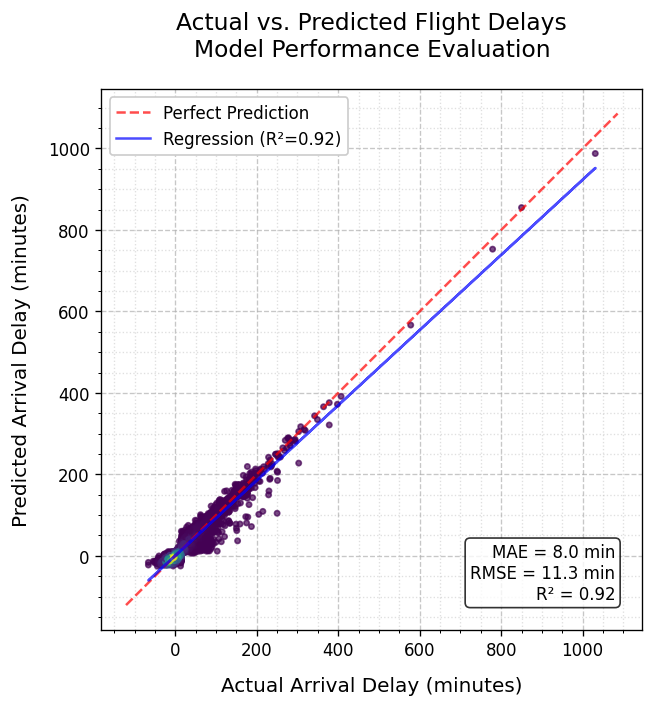

In [11]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from matplotlib.ticker import AutoMinorLocator
from scipy.stats import linregress

def create_high_quality_delay_plot(df, figsize=(10, 6), dpi=120, 
                                 regression_line=True, density_heatmap=False,
                                 metrics_box=True):
    """
    Creates a publication-quality scatter plot comparing actual vs predicted arrival delays.
    
    Parameters:
        df (pd.DataFrame): DataFrame containing 'ArrDelay' and 'Scored Labels' columns
        figsize (tuple): Figure dimensions (width, height) in inches
        dpi (int): Resolution in dots per inch
        regression_line (bool): Whether to add a linear regression line
        density_heatmap (bool): Add 2D density heatmap for high-density areas
        metrics_box (bool): Add box with performance metrics
    """
    plt.figure(figsize=figsize, dpi=dpi)
    
    # Calculate common limits
    min_val = min(df['ArrDelay'].min(), df['Scored Labels'].min())
    max_val = max(df['ArrDelay'].max(), df['Scored Labels'].max())
    buffer = (max_val - min_val) * 0.05
    
    # Create base plot
    ax = plt.gca()
    
    # Add density heatmap if requested
    if density_heatmap:
        from scipy.stats import gaussian_kde
        xy = np.vstack([df['ArrDelay'], df['Scored Labels']])
        z = gaussian_kde(xy)(xy)
        ax.scatter(df['ArrDelay'], df['Scored Labels'], c=z, s=10, alpha=0.7, cmap='viridis')
    else:
        # Regular scatter plot
        scatter = ax.scatter(
            df['ArrDelay'], 
            df['Scored Labels'],
            alpha=0.6,
            edgecolors='w',
            linewidths=0.5,
            c=np.abs(df['Scored Labels'] - df['ArrDelay']),  # Color by error magnitude
            cmap='plasma'
        )
        cbar = plt.colorbar(scatter)
        cbar.set_label('Absolute Error (minutes)', rotation=270, labelpad=15)
    
    # Add perfect prediction line (y=x)
    ax.plot([min_val-buffer, max_val+buffer], [min_val-buffer, max_val+buffer], 
           'r--', lw=1.5, alpha=0.7, label='Perfect Prediction')
    
    # Add regression line if requested
    if regression_line:
        slope, intercept, r_value, _, _ = linregress(df['ArrDelay'], df['Scored Labels'])
        ax.plot(df['ArrDelay'], slope*df['ArrDelay'] + intercept, 
               'b-', lw=1.5, alpha=0.7, 
               label=f'Regression (R²={r_value**2:.2f})')
    
    # Calculate metrics
    errors = df['Scored Labels'] - df['ArrDelay']
    mae = np.mean(np.abs(errors))
    rmse = np.sqrt(np.mean(errors**2))
    r2 = r_value**2 if regression_line else np.corrcoef(df['ArrDelay'], df['Scored Labels'])[0,1]**2
    
    # Add metrics box if requested
    if metrics_box:
        metrics_text = (f"MAE = {mae:.1f} min\n"
                      f"RMSE = {rmse:.1f} min\n"
                      f"R² = {r2:.2f}")
        props = dict(boxstyle='round', facecolor='white', alpha=0.8)
        ax.text(0.95, 0.05, metrics_text, transform=ax.transAxes,
               fontsize=10, verticalalignment='bottom', horizontalalignment='right',
               bbox=props)
    
    # Formatting
    ax.set_xlabel('Actual Arrival Delay (minutes)', fontsize=12, labelpad=10)
    ax.set_ylabel('Predicted Arrival Delay (minutes)', fontsize=12, labelpad=10)
    ax.set_title('Actual vs. Predicted Flight Delays\nModel Performance Evaluation', 
                fontsize=14, pad=20)
    
    # Grid and ticks
    ax.set_axisbelow(True)
    ax.grid(True, which='major', linestyle='--', alpha=0.7)
    ax.grid(True, which='minor', linestyle=':', alpha=0.4)
    ax.xaxis.set_minor_locator(AutoMinorLocator())
    ax.yaxis.set_minor_locator(AutoMinorLocator())
    
    # Set equal aspect ratio
    ax.set_aspect('equal', adjustable='box')
    
    # Legend and layout
    ax.legend(fontsize=10, framealpha=1, loc='upper left')
    plt.tight_layout()
    
    return plt

# Usage example:
plot = create_high_quality_delay_plot(df, 
                                    density_heatmap=True, 
                                    metrics_box=True)
plot.show()

<mark>###**Residual error analysis**</mark>

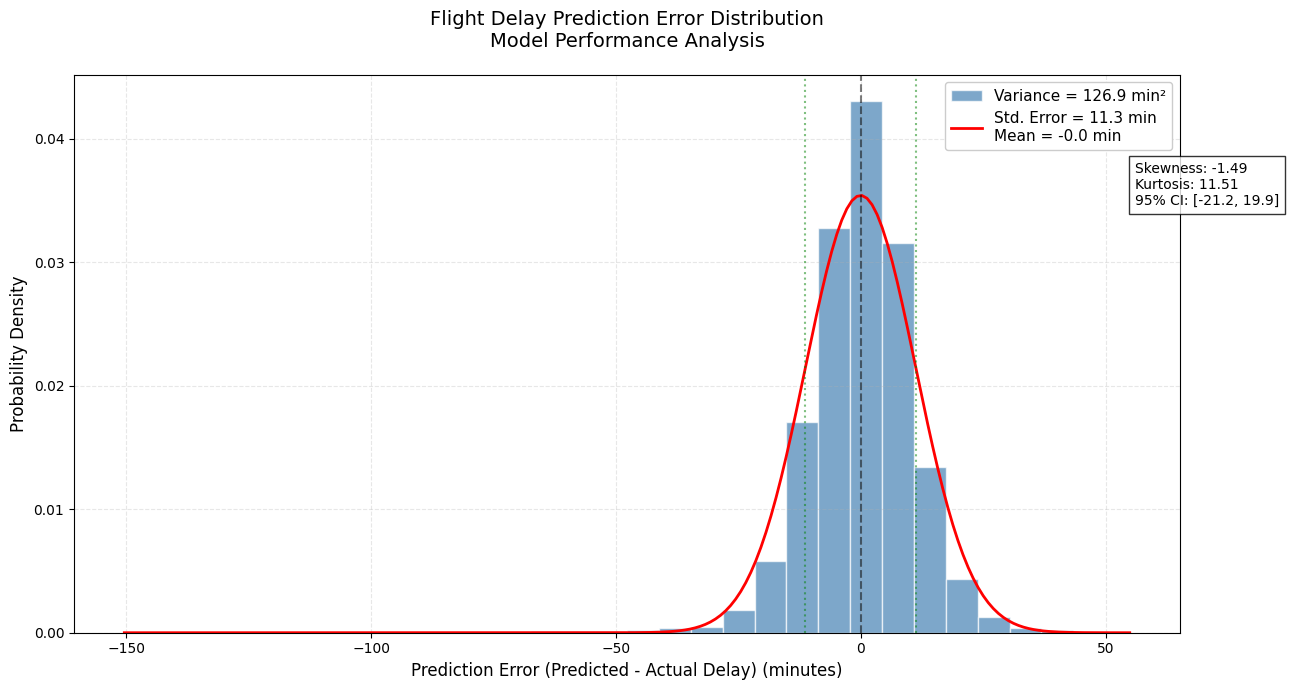


Additional Diagnostics:
Mean Absolute Error (MAE): 8.04 minutes
Root Mean Squared Error (RMSE): 11.27 minutes
Percentage within ±15 mins: 87.4%


In [14]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import norm

# 1. Calculate residuals (Predicted - Actual)
residuals = df['Scored Labels'] - df['ArrDelay']

# 2. Compute variance and standard error
residual_variance = np.var(residuals, ddof=1)  # Using ddof=1 for sample variance
std_error = np.sqrt(residual_variance)

# 3. Plot residual distribution with enhanced formatting
plt.figure(figsize=(12, 7), dpi=100)

# Histogram with density scaling
n, bins, patches = plt.hist(residuals, bins=30, density=True, alpha=0.7, 
                           color='steelblue', edgecolor='white',
                           label=f'Variance = {residual_variance:.1f} min²')

# Overlay normal distribution curve
xmin, xmax = min(residuals)-5, max(residuals)+5  # Adding buffer space
x = np.linspace(xmin, xmax, 200)
p = norm.pdf(x, np.mean(residuals), std_error)
plt.plot(x, p, 'r-', linewidth=2, 
         label=f'Std. Error = {std_error:.1f} min\nMean = {np.mean(residuals):.1f} min')

# Add vertical lines for mean and ±1 std
plt.axvline(np.mean(residuals), color='k', linestyle='--', alpha=0.5)
plt.axvline(np.mean(residuals) + std_error, color='g', linestyle=':', alpha=0.5)
plt.axvline(np.mean(residuals) - std_error, color='g', linestyle=':', alpha=0.5)

# Formatting
plt.xlabel('Prediction Error (Predicted - Actual Delay) (minutes)', fontsize=12)
plt.ylabel('Probability Density', fontsize=12)
plt.title('Flight Delay Prediction Error Distribution\nModel Performance Analysis', 
         fontsize=14, pad=20)
plt.legend(fontsize=11, framealpha=1)
plt.grid(True, linestyle='--', alpha=0.3)

# Add text box with additional statistics
stats_text = (f"Skewness: {stats.skew(residuals):.2f}\n"
             f"Kurtosis: {stats.kurtosis(residuals):.2f}\n"
             f"95% CI: [{np.percentile(residuals, 2.5):.1f}, {np.percentile(residuals, 97.5):.1f}]")
plt.gcf().text(0.95, 0.7, stats_text, fontsize=10, 
              bbox=dict(facecolor='white', alpha=0.8))

plt.tight_layout()
plt.show()

# Print additional diagnostics
print("\nAdditional Diagnostics:")
print(f"Mean Absolute Error (MAE): {np.mean(np.abs(residuals)):.2f} minutes")
print(f"Root Mean Squared Error (RMSE): {np.sqrt(np.mean(residuals**2)):.2f} minutes")
print(f"Percentage within ±15 mins: {100*np.mean(np.abs(residuals) <= 15):.1f}%")

In [1]:
pip install statsmodels

Note: you may need to restart the kernel to use updated packages.


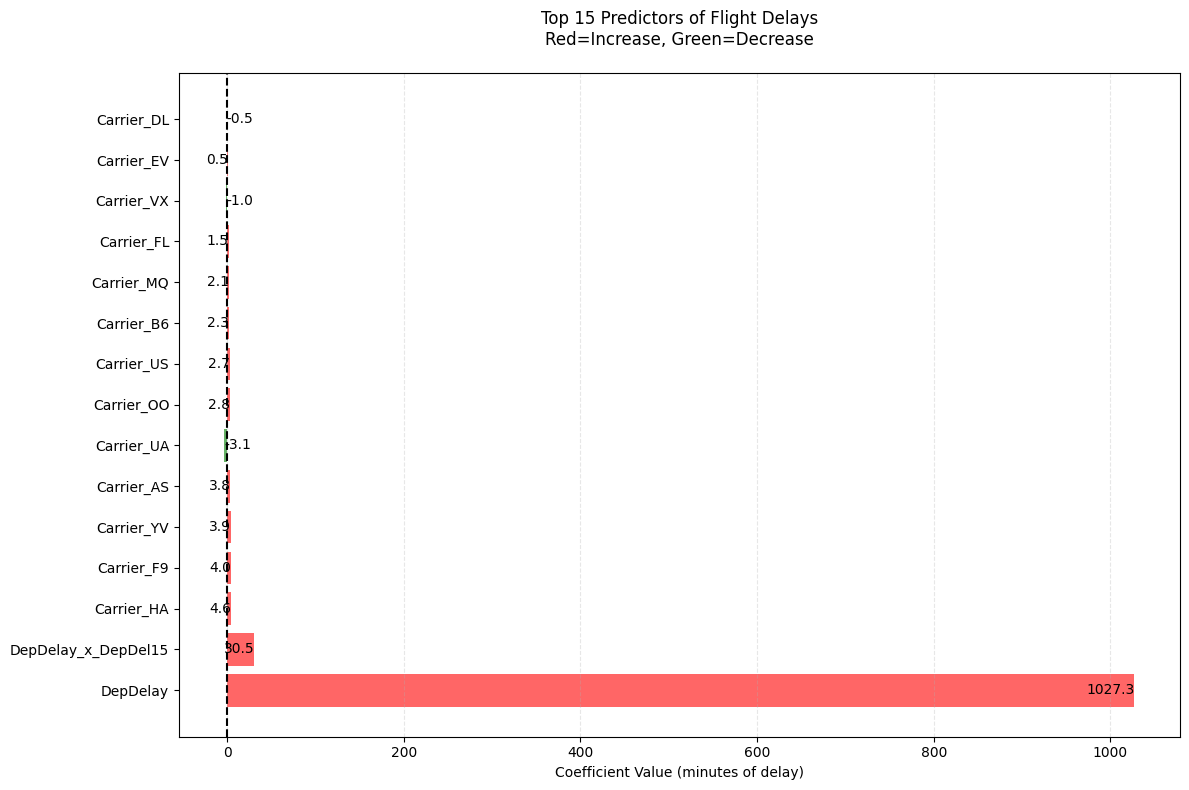

=== Model Summary ===
R-squared: 0.897
Adjusted R-squared: 0.897
MAE: 8.9 minutes
RMSE: 12.9 minutes


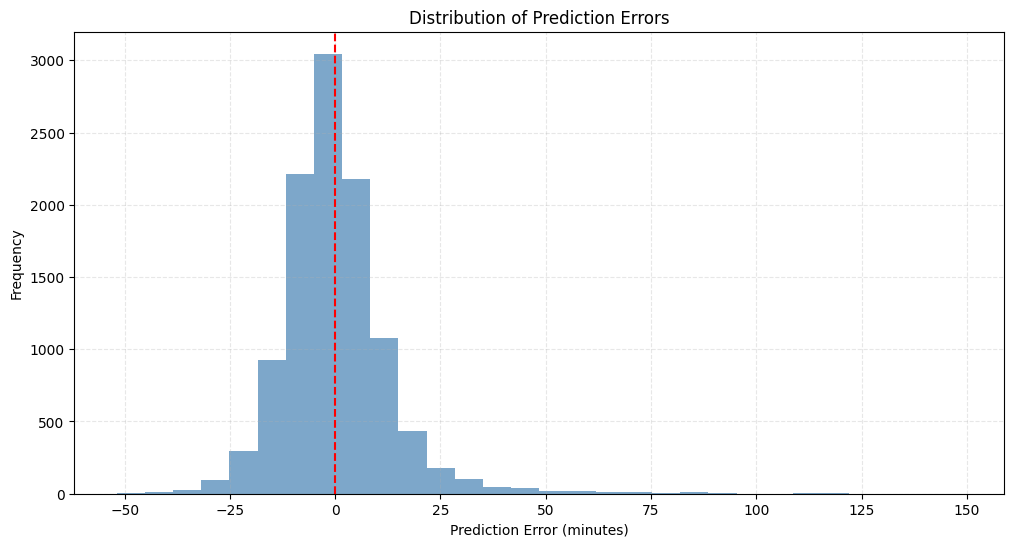


=== Top Delay Contributors ===
DepDelay               1027.325508
DepDelay_x_DepDel15      30.483738
Carrier_HA                4.588768
Carrier_F9                4.004083
Carrier_YV                3.936769
Carrier_AS                3.751226

=== Top On-Time Improvers ===
const        -24.844563
Carrier_UA    -3.052942
Carrier_VX    -1.009789
Carrier_DL    -0.505568
Carrier_AA    -0.317014


In [23]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
import matplotlib.pyplot as plt

# 1. Data Preparation
def prepare_data(df):
    """Prepares the flight delay data for analysis"""
    df_clean = df.copy()
    
    # Convert binary flags
    df_clean['DepDel15'] = df_clean['DepDel15'].astype(int)
    df_clean['ArrDel15'] = df_clean['ArrDel15'].astype(int)
    
    # Handle normalized columns
    if 'DayofMonth' in df_clean.columns:
        df_clean['DayofMonth'] = np.round(df_clean['DayofMonth'] * 30 + 1).astype(int)
    if 'CRSDepTime' in df_clean.columns:
        df_clean['CRSDepTime'] = df_clean['CRSDepTime'] * 24
    if 'CRSArrTime' in df_clean.columns:
        df_clean['CRSArrTime'] = df_clean['CRSArrTime'] * 24
    
    return df_clean

df_analysis = prepare_data(df)

# 2. Feature Engineering
features = ['Month', 'DayOfWeek', 'DayofMonth', 'CRSDepTime', 'DepDelay', 
            'DepDel15', 'Carrier', 'OriginAirportID', 'DestAirportID']

# Create interaction term
df_analysis['DepDelay_x_DepDel15'] = df_analysis['DepDelay'] * df_analysis['DepDel15']
features.append('DepDelay_x_DepDel15')

# Create dummy variables
X = pd.get_dummies(df_analysis[features], columns=['Carrier'], drop_first=True)
y = df_analysis['ArrDelay']

# Add intercept and fit model
X = sm.add_constant(X)
model = sm.OLS(y, X).fit()

# 3. Coefficient Analysis
def plot_coefficients(model, top_n=15):
    """Visualizes the most important coefficients"""
    # Get coefficients and sort by absolute value
    coefs = model.params.drop('const')
    coefs = coefs.reindex(coefs.abs().sort_values(ascending=False).index)
    
    # Filter top N significant coefficients
    significant = coefs.head(top_n)
    
    # Create plot
    plt.figure(figsize=(12, 8))
    colors = ['red' if x > 0 else 'green' for x in significant]
    y_pos = np.arange(len(significant))
    
    plt.barh(y_pos, significant, color=colors, alpha=0.6)
    plt.yticks(y_pos, significant.index)
    plt.axvline(0, color='black', linestyle='--')
    
    # Add coefficient values
    for i, v in enumerate(significant):
        plt.text(v, i, f"{v:.1f}", 
                color='black', va='center',
                ha='left' if v < 0 else 'right')
    
    plt.xlabel('Coefficient Value (minutes of delay)')
    plt.title(f'Top {top_n} Predictors of Flight Delays\nRed=Increase, Green=Decrease', pad=20)
    plt.grid(axis='x', linestyle='--', alpha=0.3)
    plt.tight_layout()
    plt.show()

plot_coefficients(model)

# 4. Model Diagnostics
print("=== Model Summary ===")
print(f"R-squared: {model.rsquared:.3f}")
print(f"Adjusted R-squared: {model.rsquared_adj:.3f}")
print(f"MAE: {np.mean(np.abs(model.resid)):.1f} minutes")
print(f"RMSE: {np.sqrt(np.mean(model.resid**2)):.1f} minutes")

# 5. Residual Analysis
plt.figure(figsize=(12, 6))
plt.hist(model.resid, bins=30, color='steelblue', alpha=0.7)
plt.axvline(0, color='red', linestyle='--')
plt.xlabel('Prediction Error (minutes)')
plt.ylabel('Frequency')
plt.title('Distribution of Prediction Errors')
plt.grid(True, linestyle='--', alpha=0.3)
plt.show()

# 6. Print top predictors
print("\n=== Top Delay Contributors ===")
print(model.params.sort_values(ascending=False).head(6).to_string())  # Includes intercept

print("\n=== Top On-Time Improvers ===")
print(model.params.sort_values().head(5).to_string())